In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Due to the problem's nature, try to create features that give an idea of the location 
# of passengers during the abnormality

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print(df_train.columns)
print()
null_values_per_column = df_train.isnull().sum()
print(null_values_per_column)

print()
print(df_train.describe())
print()

print()
print(df_train.dtypes)
print()
# HomePlanet Feature
print("HomePlanet uniques:", df_train["HomePlanet"].unique())
n_HomePlanet_uniques = df_train["HomePlanet"].unique().shape[0]
print("HomePlanet unique count:", n_HomePlanet_uniques)

# Cabin Feature
print("Cabin uniques:", df_train["Cabin"].unique())
n_Cabin_uniques = df_train["Cabin"].unique().shape[0]
print("Cabin unique count:", n_Cabin_uniques)

# Destination Feature
print("Destination uniques:", df_train["Destination"].unique())
n_Destination_uniques = df_train["Destination"].unique().shape[0]
print("Destination unique count:", n_Destination_uniques)
print()

# Attention to 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' features,
# they looks like to have many outliers

# Null values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=20, random_state=0)
imp.fit(df_train)
df_test = imp.transform(df_train)
print(df_test)

df_train = df_train.dropna() # Only for now

indexes = df_train.index
n = df_train.shape[0]


Train shape: (8693, 14)
Test shape: (4277, 13)
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000

ValueError: could not convert string to float: 'Europa'

# Group Size

Size 1 | Transported Rate = 0.4638149714001492
Size 2 | Transported Rate = 0.5443037974683544
Size 3 | Transported Rate = 0.5900709219858156
Size 4 | Transported Rate = 0.6129032258064516
Size 5 | Transported Rate = 0.5764705882352941
Size 6 | Transported Rate = 0.5333333333333333
Size 7 | Transported Rate = 0.6
Size 8 | Transported Rate = 0.25
GroupSize
0    4021
1    2217
2     368
Name: count, dtype: int64


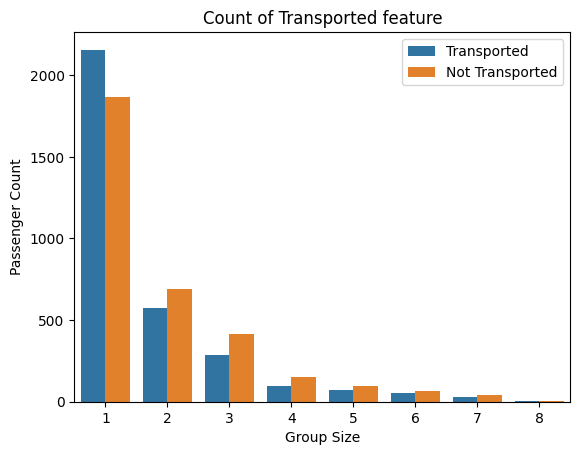

In [71]:
df_copy = df_train.copy()
df_copy["PassengerId"] = df_copy["PassengerId"].apply(lambda x: int(x[:4]))
values_frequency = df_copy["PassengerId"].value_counts()
df_copy["GroupSize"] = df_copy["PassengerId"].apply(lambda x: values_frequency.loc[x])

for i in range(1,9):
    group_i = df_copy[df_copy["GroupSize"] == i ]
    transported_i = group_i[ group_i["Transported"] == True ]
    print("Size {} | Transported Rate = {}".format( i , transported_i.shape[0] / group_i.shape[0] ))

ax = sns.countplot(x='GroupSize', hue='Transported', data=df_copy)
plt.xlabel('Group Size')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")

def final_categories(x):
    if x == 1: 
        return 0 # Singular "group"

    elif x <= 4:
        return 1 # Medium group

    else:
        return 2 # Big group
        
df_train["GroupSize"] = df_copy["GroupSize"].apply(final_categories)
print(df_train["GroupSize"].value_counts())

# Family Size

Size 1 | Transported Rate = 0.5619834710743802
Size 2 | Transported Rate = 0.5222222222222223
Size 3 | Transported Rate = 0.5062034739454094
Size 4 | Transported Rate = 0.5138888888888888
Size 5 | Transported Rate = 0.48520710059171596
Size 6 | Transported Rate = 0.48333333333333334
Size 7 | Transported Rate = 0.468384074941452
Size 8 | Transported Rate = 0.42934782608695654
Size 9 | Transported Rate = 0.5146198830409356
Size 10 | Transported Rate = 0.5052631578947369
Size 11 | Transported Rate = 0.5636363636363636
Size 12 | Transported Rate = 0.3888888888888889
Size 13 | Transported Rate = 0.5128205128205128
Size 15 | Transported Rate = 0.3333333333333333
Size 17 | Transported Rate = 0.35294117647058826
FamilySize
0    3907
1    2176
2     523
Name: count, dtype: int64


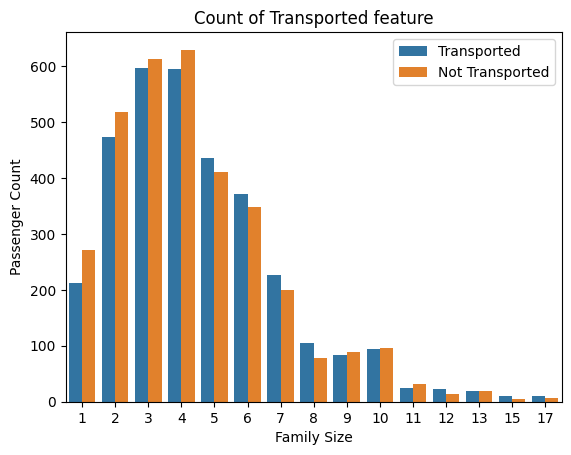

In [72]:
df_copy = df_train.copy()
df_copy["Name"] = df_copy["Name"].apply(lambda x: x.split()[-1])
values_frequency = df_copy["Name"].value_counts()
df_copy["FamilySize"] = df_copy["Name"].apply(lambda x: values_frequency.loc[x])

for i in range(1,18):
    group_i = df_copy[df_copy["FamilySize"] == i ]
    if group_i.shape[0] == 0: continue
    transported_i = group_i[ group_i["Transported"] == True ]
    print("Size {} | Transported Rate = {}".format( i , transported_i.shape[0] / group_i.shape[0] ))

ax = sns.countplot(x='FamilySize', hue='Transported', data=df_copy)
plt.xlabel('Family Size')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")

def final_categories(x):
    if x <= 4: 
        return 0 # Small family

    elif x <= 8:
        return 1 # Medium family

    else:
        return 2 # Big family
        
df_train["FamilySize"] = df_copy["FamilySize"].apply(final_categories)
print(df_train["FamilySize"].value_counts())

# Analysing: HomePlanet and Destination 

In [73]:
df_copy = df_train.copy()

for home_name in df_copy["HomePlanet"].unique():
    df_ishome = df_copy["HomePlanet"] == home_name
    df_train[home_name] = df_ishome
    n_transported = (df_copy[df_ishome]["Transported"]==True).sum()
    print("Home: {}, Transported Rate: {}".format(home_name, n_transported/n))

for destination_name in df_copy["Destination"].unique():
    df_isdestination = df_copy["Destination"] == destination_name
    df_train[destination_name] = df_isdestination
    n_transported = (df_copy[df_isdestination]["Transported"]==True).sum()
    print("Home: {}, Transported Rate: {}".format(destination_name, n_transported/n))


Home: Europa, Transported Rate: 0.16712079927338783
Home: Earth, Transported Rate: 0.22979109900090827
Home: Mars, Transported Rate: 0.1067211625794732
Home: TRAPPIST-1e, Transported Rate: 0.32334241598546776
Home: PSO J318.5-22, Transported Rate: 0.047683923705722074
Home: 55 Cancri e, Transported Rate: 0.13260672116257946


# Analysing: Cabin

In [74]:
df_copy = df_train.copy()
decks = sorted(df_copy["Cabin"].apply(lambda x: x[0]).unique())
print("Decks:")
for deck in decks:
    df_isdeck = df_copy["Cabin"].apply(lambda x:x[0]) == deck
    df_train["Deck_"+deck] = df_isdeck
    n_deck = df_isdeck.sum()
    n_transported = (df_copy[df_isdeck]["Transported"] == True).sum()
    print(deck, n_transported/n_deck)
    print(n_transported, n_deck)

print("Sides:")
sides = sorted(df_copy["Cabin"].apply(lambda x: x[-1]).unique())
for side in sides:
    df_isside = df_copy["Cabin"].apply(lambda x:x[-1]) == side
    df_train["Side_"+side] = df_isside
    n_side = df_isside.sum()
    n_transported = (df_copy[df_isside]["Transported"] == True).sum()
    print(side, n_transported/n_side)
    print(n_transported, n_side)

df_train = df_train.drop("Deck_T", axis = 1)


Decks:
A 0.48792270531400966
101 207
B 0.7292993630573248
458 628
C 0.6797274275979557
399 587
D 0.42245989304812837
158 374
E 0.35871156661786235
245 683
F 0.4354089219330855
937 2152
G 0.5210339584389255
1028 1973
T 0.5
1 2
Sides:
P 0.44986200551977923
1467 3261
S 0.5560538116591929
1860 3345


# Comparing Transported and Not Transported stats

In [75]:
# Comparing Transported and Not Transported dataframes
transported_df = df_train[ df_train["Transported"] == True ]
not_transported_df = df_train[ df_train["Transported"] == False ]

transported_stats = transported_df.describe()
not_transported_stats = not_transported_df.describe()

comparing_df = pd.DataFrame()
comparing_df["T Mean"] = transported_stats.loc["mean"]
comparing_df["NT Mean"] = not_transported_stats.loc["mean"]
comparing_df["T Std"] = transported_stats.loc["std"]
comparing_df["NT Std"] = not_transported_stats.loc["std"]

print(comparing_df)

                  T Mean     NT Mean        T Std       NT Std
Age            27.703036   30.102470    15.266569    13.646138
RoomService    64.658852  383.642269   282.632489   840.194088
FoodCourt     570.646829  385.928027  2028.337287  1218.965709
ShoppingMall  184.993989  171.621836   658.200425   479.178761
Spa            63.484521  566.493443   264.541400  1561.613357
VRDeck         71.105801  539.860323   294.972045  1536.525218
GroupSize       0.501353    0.391888     0.611511     0.580711
FamilySize      0.467989    0.507777     0.636706     0.640687


# Analysing the five money features

## RoomService

count    6606.000000
mean        4.550850
std        13.163019
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       202.448980
Name: RoomService, dtype: float64
RoomService
0    4318
2    2022
1     266
Name: count, dtype: int64


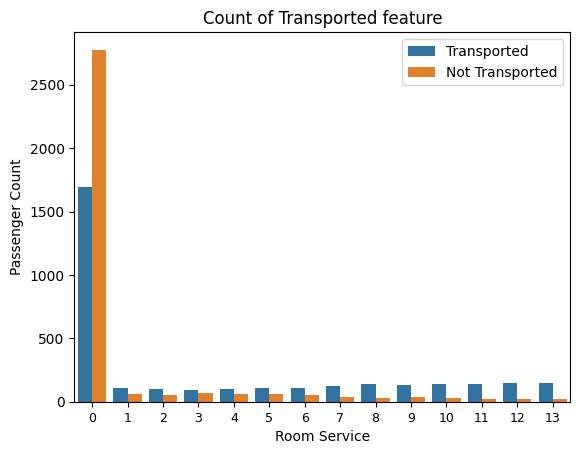

In [76]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["RoomService"] = scaler.fit_transform(np.array(df_copy["RoomService"]).reshape(-1,1))
print(df_copy["RoomService"].describe())
df_copy["RoomService"] = pd.qcut(df_copy["RoomService"], 40, duplicates = "drop")
all_intervals = df_copy["RoomService"].cat.categories


#df_copy["RoomService"] = pd.cut(df_copy["RoomService"], [-1, 0.01, 2.5, 250])

ax = sns.countplot(x='RoomService', hue='Transported', data=df_copy)
plt.xlabel('Room Service')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["RoomService"] = label_encoder.fit_transform(df_copy["RoomService"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 6:
        return 1

    else:
        return 2
        
df_train["RoomService"] = df_train["RoomService"].apply(final_categories)
print(df_train["RoomService"].value_counts())

## FoodCourt

count    6606.000000
mean        5.788018
std        20.285103
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       360.277946
Name: FoodCourt, dtype: float64
FoodCourt
0    4241
4    1938
1     349
2      54
3      24
Name: count, dtype: int64


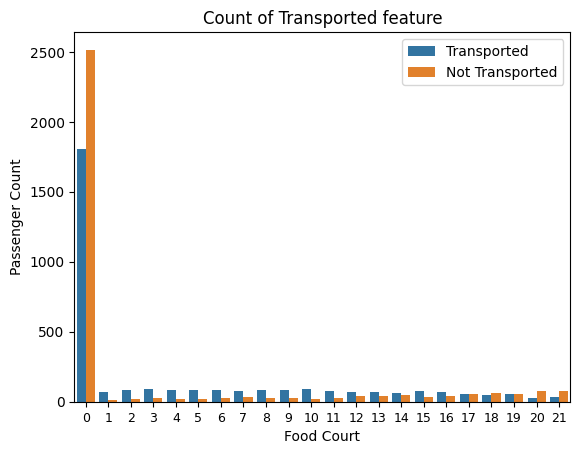

In [77]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["FoodCourt"] = scaler.fit_transform(np.array(df_copy["FoodCourt"]).reshape(-1,1))
print(df_copy["FoodCourt"].describe())
df_copy["FoodCourt"] = pd.qcut(df_copy["FoodCourt"], 60, duplicates = "drop")
all_intervals = df_copy["FoodCourt"].cat.categories



ax = sns.countplot(x='FoodCourt', hue='Transported', data=df_copy)
plt.xlabel('Food Court')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["FoodCourt"] = label_encoder.fit_transform(df_copy["FoodCourt"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 11:
        return 1

    elif x <= 16:
        return 2

    elif x <= 19:
        return 3
        
    else:
        return 4
        
df_train["FoodCourt"] = df_train["FoodCourt"].apply(final_categories)
print(df_train["FoodCourt"].value_counts())

## ShoppingMall  

count    6606.000000
mean        5.945216
std        19.210947
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       408.433333
Name: ShoppingMall, dtype: float64
ShoppingMall
0    4332
3    1741
1     480
2      53
Name: count, dtype: int64


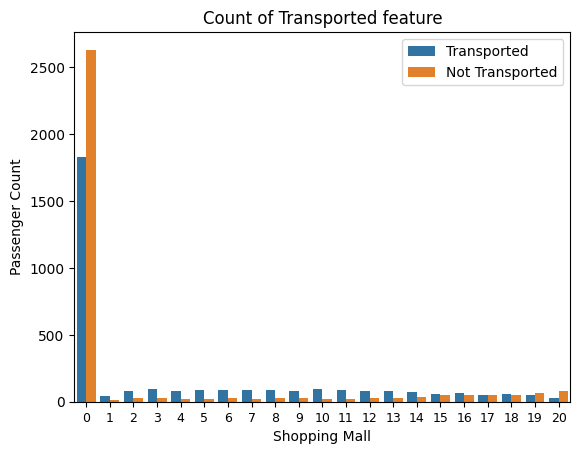

In [78]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["ShoppingMall"] = scaler.fit_transform(np.array(df_copy["ShoppingMall"]).reshape(-1,1))
print(df_copy["ShoppingMall"].describe())
df_copy["ShoppingMall"] = pd.qcut(df_copy["ShoppingMall"], 60, duplicates = "drop")
all_intervals = df_copy["ShoppingMall"].cat.categories



ax = sns.countplot(x='ShoppingMall', hue='Transported', data=df_copy)
plt.xlabel('Shopping Mall')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["ShoppingMall"] = label_encoder.fit_transform(df_copy["ShoppingMall"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 14:
        return 1

    elif x <= 18:
        return 2
        
    else:
        return 3
        
df_train["ShoppingMall"] = df_train["ShoppingMall"].apply(final_categories)
print(df_train["ShoppingMall"].value_counts())

## Spa

count    6606.000000
mean        4.817870
std        17.600251
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       344.738462
Name: Spa, dtype: float64
Spa
0    4109
4    1931
1     432
2      76
3      58
Name: count, dtype: int64


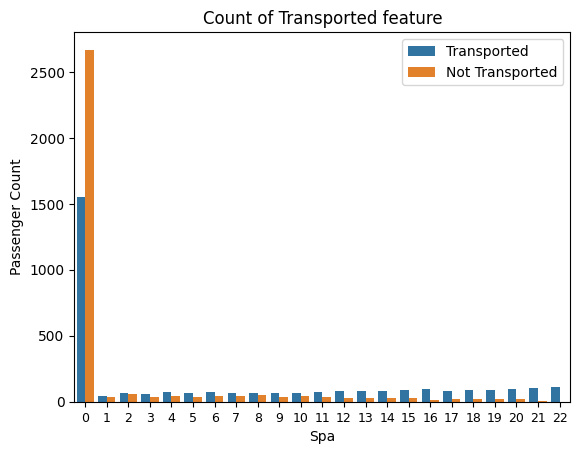

In [79]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["Spa"] = scaler.fit_transform(np.array(df_copy["Spa"]).reshape(-1,1))
print(df_copy["Spa"].describe())
df_copy["Spa"] = pd.qcut(df_copy["Spa"], 60, duplicates = "drop")
all_intervals = df_copy["Spa"].cat.categories



ax = sns.countplot(x='Spa', hue='Transported', data=df_copy)
plt.xlabel('Spa')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["Spa"] = label_encoder.fit_transform(df_copy["Spa"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 10:
        return 1

    elif x <= 15:
        return 2

    elif x <= 20:
        return 3
        
    else:
        return 4
        
df_train["Spa"] = df_train["Spa"].apply(final_categories)
print(df_train["Spa"].value_counts())

## VRDeck

count    6606.000000
mean        5.841924
std        21.675811
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       391.076923
Name: VRDeck, dtype: float64
VRDeck
0    4241
3    1857
1     451
2      57
Name: count, dtype: int64


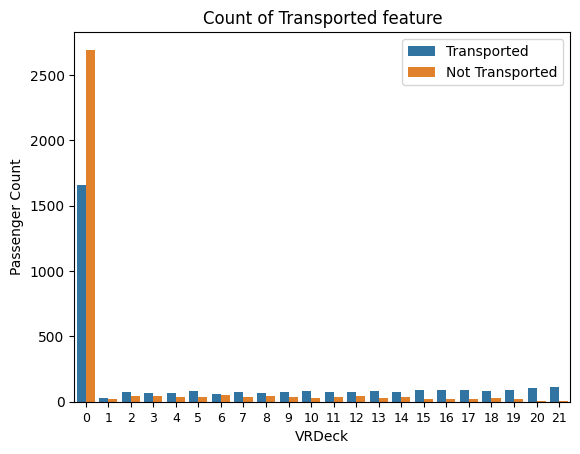

In [80]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["VRDeck"] = scaler.fit_transform(np.array(df_copy["VRDeck"]).reshape(-1,1))
print(df_copy["VRDeck"].describe())
df_copy["VRDeck"] = pd.qcut(df_copy["VRDeck"], 60, duplicates = "drop")
all_intervals = df_copy["VRDeck"].cat.categories



ax = sns.countplot(x='VRDeck', hue='Transported', data=df_copy)
plt.xlabel('VRDeck')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["VRDeck"] = label_encoder.fit_transform(df_copy["VRDeck"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 14:
        return 1

    elif x <= 19:
        return 2
        
    else:
        return 3
        
df_train["VRDeck"] = df_train["VRDeck"].apply(final_categories)
print(df_train["VRDeck"].value_counts())

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'GroupSize', 'FamilySize', 'Europa',
       'Earth', 'Mars', 'TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Side_P', 'Side_S'],
      dtype='object')

Transported      1.000000
CryoSleep        0.462803
Europa           0.182004
Deck_B           0.146288
55 Cancri e      0.123783
Deck_C           0.109988
Side_S           0.106186
GroupSize        0.091395
Deck_G           0.022711
Mars             0.012357
PSO J318.5-22    0.001281
Deck_A          -0.005651
FamilySize      -0.031137
Deck_D          -0.039772
VIP             -0.042260
Age             -0.082553
Deck_F          -0.094847
Deck_E          -0.098427
Side_P          -0.106186
TRAPPIST-1e     -0.110655
Earth           -0.168845
FoodCourt       -0.184090
ShoppingMall    -0.228404
VRDeck          -0.327086
RoomService     -0.3469

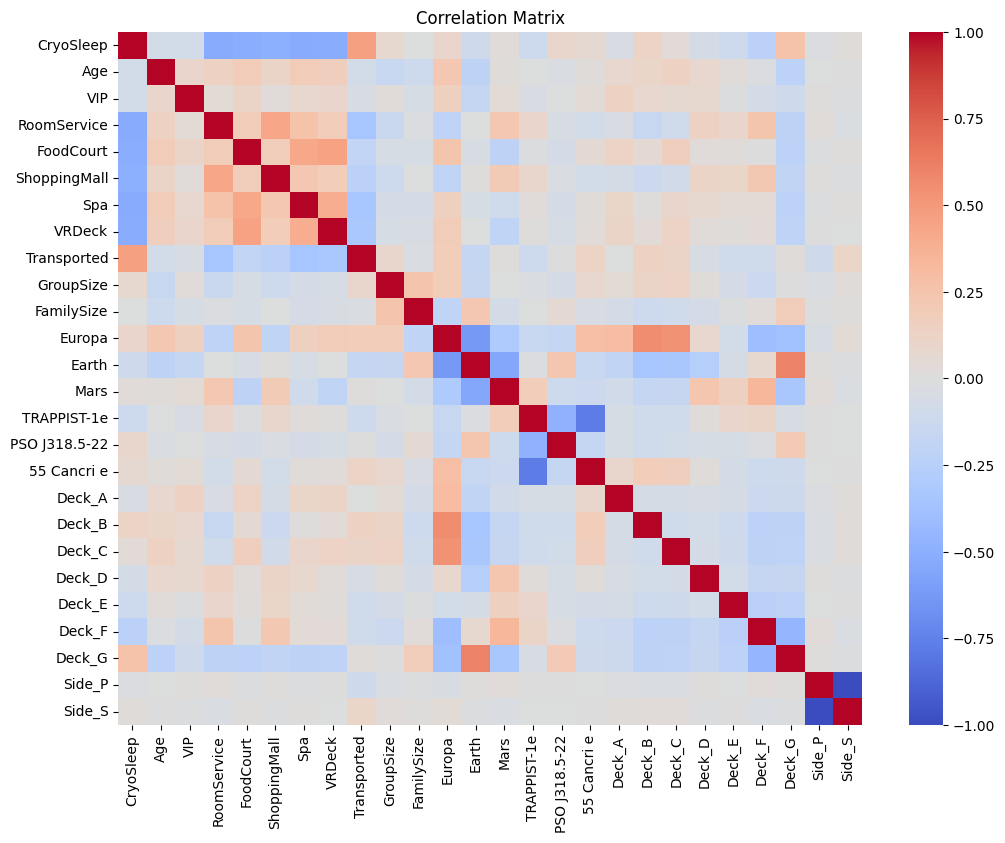

In [81]:
correlation_df = df_train.copy()
correlation_df = correlation_df.drop(columns = ["PassengerId", "HomePlanet", "Cabin", "Destination", "Name"])
print(correlation_df.columns)
print()
correlation_matrix = correlation_df.corr()
print(correlation_matrix["Transported"].sort_values(ascending = False).T)

plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', annot_kws={"size": 12})
plt.title('Correlation Matrix')
plt.show()




In [82]:
print(df_train)

     PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall  ...  55